## The images
Below are the 2 images used, let's also define the aspect ratio of the europe map

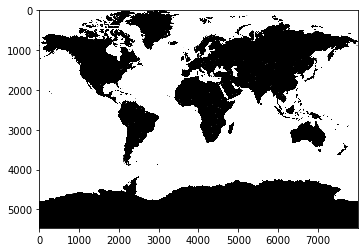

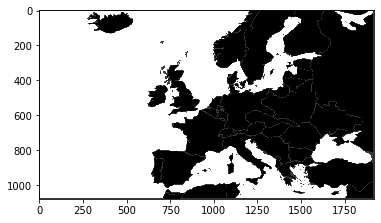

Aspect Ratio of europe :  1.7777777777777777


In [4]:
from skimage import color, io
import numpy as np
from matplotlib import pyplot as plt
def display_img(img, title="", big=False) : 
    if big : 
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

world_picture = color.rgb2gray(color.rgba2rgb(io.imread('input/world.png')))
display_img(world_picture)
europe_picture = color.rgb2gray(io.imread('input/europe_thuned_3colors.png'))
display_img(europe_picture)
aspect_ratio = europe_picture.shape[1]/ europe_picture.shape[0]
print('Aspect Ratio of europe : ', aspect_ratio)

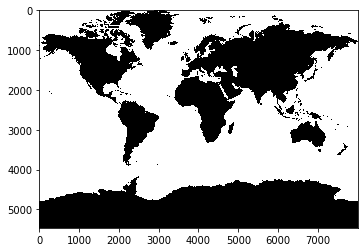

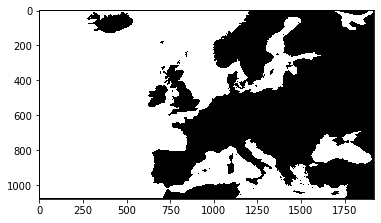

In [5]:
# Both pictures as black and white binary images, in order to focus on comparing the coasts
world_picture[world_picture>0.5] = 1
world_picture[world_picture<0.5] = 0
europe_picture[europe_picture<0.5]  = 0
europe_picture[europe_picture>0.5] = 1
display_img(world_picture)
display_img(europe_picture)

## Locate an image within another, given its size
open CV `matchTemplate` method is used here

In [6]:
# returns the x, y coordinates of the template within the world
def getPosition(world, template) : 
    template = template.astype(np.float32) # 1
    world = world.astype(np.float32)
    res = cv2.matchTemplate(world, template, cv2.TM_CCOEFF) # 2
    _, _, _, (x, y) = cv2.minMaxLoc(res) # 3
    return x, y

The method 
1. converts both images to required types, 
2. Extracts a heatmap of the world, each pixel represents the probability of the template to be located there
3. Extracts the coordinates of the maximum probability pixel

Found location : (3046, 803)


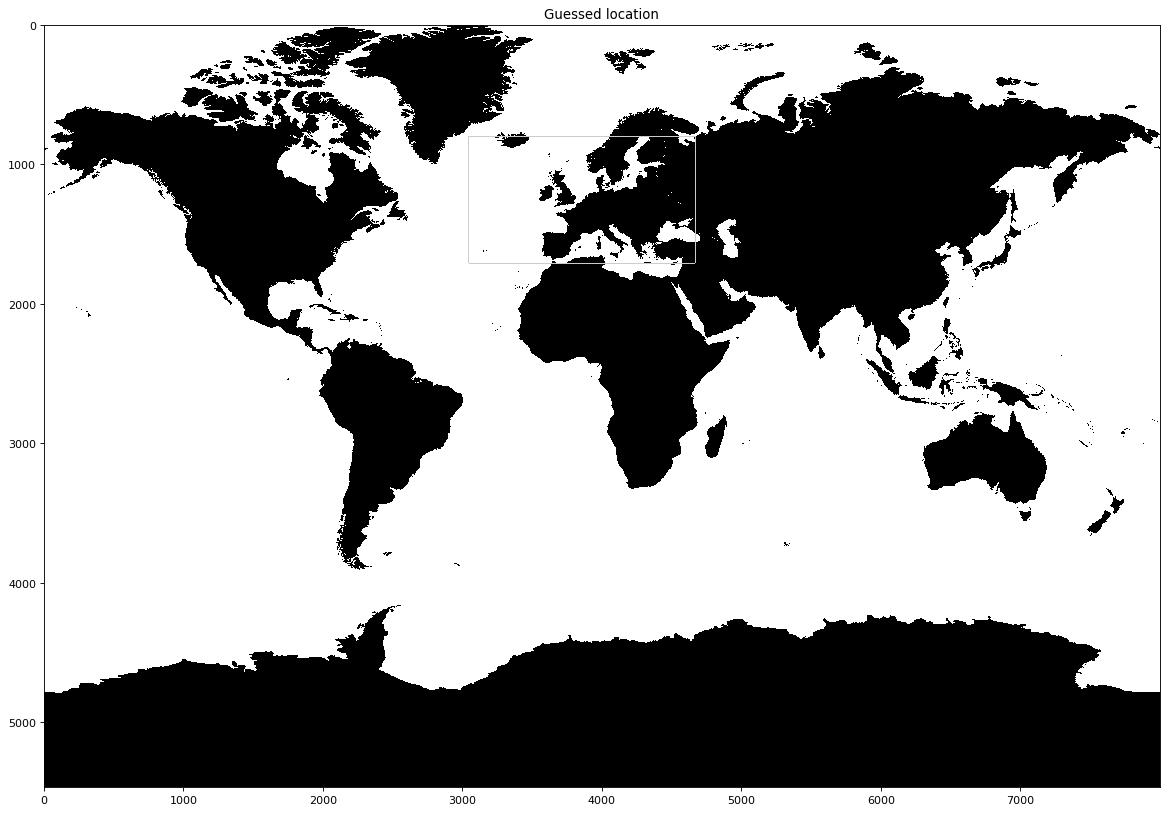

In [7]:
import cv2

def display_location_on_world_map(x, y, width) :
    height = int(width/ratio)
    bottom_right = (x + width, y + height)
    located = world_picture.copy()
    cv2.rectangle(located, (x, y), bottom_right, 0.8, 6)
    display_img(located, "Guessed location", True)


empirical_width = 1621
template = cv2.resize(europe_picture, (empirical_width, int(empirical_width/ratio)))
x_ok, y_ok = getPosition(world_picture, template)
print('Found location :', (x_ok, y_ok))
display_location_on_world_map(x_ok, y_ok, empirical_width)

Now with a wrong predicted width : 

Found location : (3345, 1917)


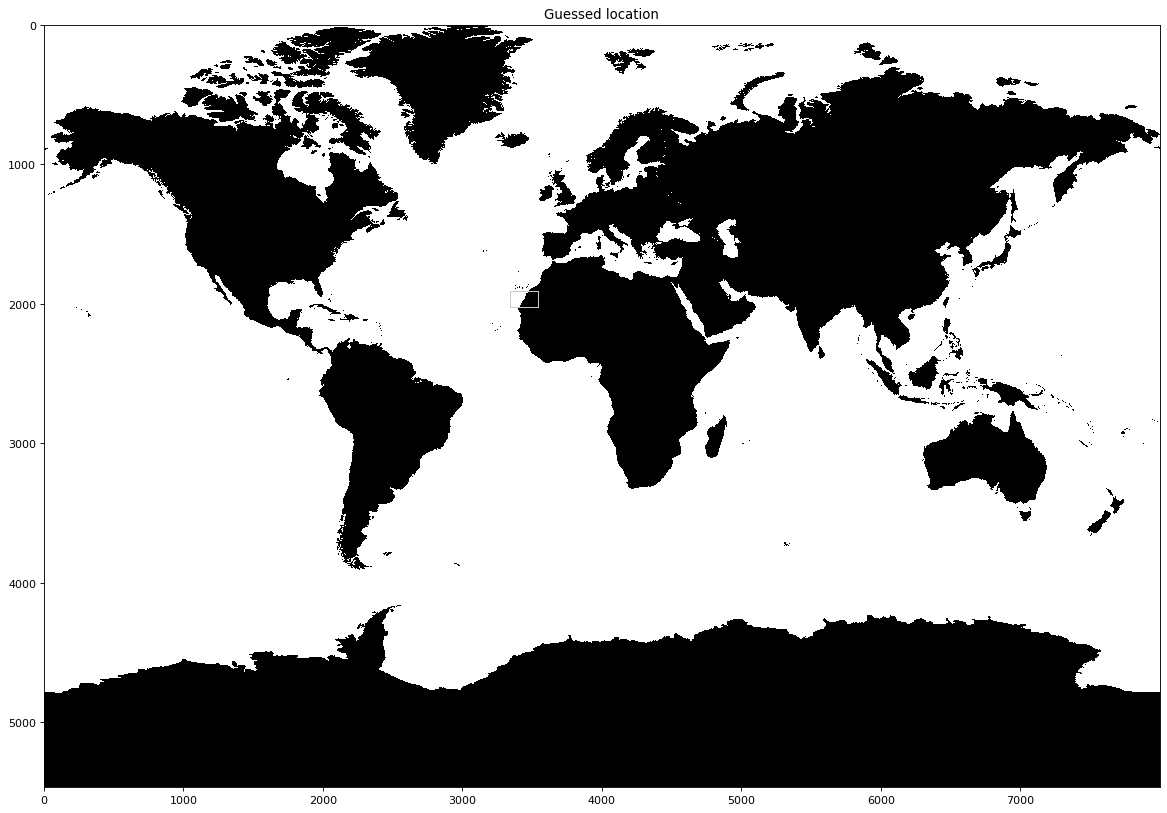

In [8]:
wrong_empirical_width = 200
template = cv2.resize(europe_picture, (wrong_empirical_width, int(wrong_empirical_width/ratio)))
x_wrong, y_wrong = getPosition(world_picture, template)
print('Found location :', (x_wrong, y_wrong))
display_location_on_world_map(x_wrong, y_wrong, wrong_empirical_width)

Width matters. So let's work an algorithm testing multiple versions of the width to predict the most accurate one. 
## Evaluating a prediction
The `matchTemplate` method does not tell us how accurate the result is. Let's define a measure of accuracy between the template and its prediction.

In [9]:
# Computes how a template is accurate to its predicted by multiplying the proportion of well 
# predicted land by the proportion of well predicted sea
def image_equality_score(template, match):
    if(template.shape != match.shape):
        raise Exception('Both images must be the same size')
    tp_copy = template.copy() # 1
    match_copy = match.copy()
    tp_copy[tp_copy<1] = 0
    match_copy[match_copy<1] = 0
    nb_pixel_land = np.count_nonzero(tp_copy) # 2
    nb_pixel_sea = tp_copy[tp_copy==1].sum()
    sea_score =  np.logical_and(tp_copy, match_copy).sum() / nb_pixel_sea # 3
    land_score = np.logical_and(np.logical_not(tp_copy), np.logical_not(match_copy)).sum() / nb_pixel_land # 4
    return land_score * sea_score



How the `image_equality_score` function works : 
1. It makes both images binary (copy them first in order not to alter the original images)
2. Computes the number of land / sea pixels on the real europe
3. Performs a logical AND between the 2 images (a sea pixel = 1), so it only keeps the pixels that are sea in both images. Then it divides this sea pixel count by the sea pixel count on original europe
4. Same as 3), but initially performs a not to transform black (=land) into white (=sea)

Precise location of europe


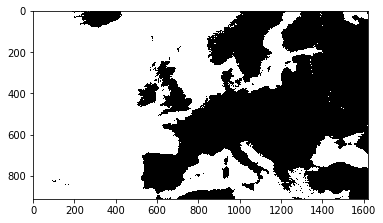

Accuracy score :  0.638661697181673


Wrong location of europe


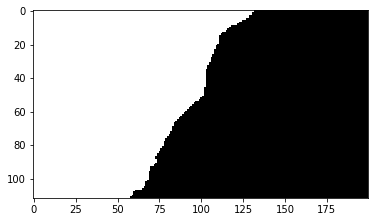

Accuracy score :  0.5346370905895634


In [10]:
# x,y is the predicated position of europe on the world map
# width is the predicted width of europe on the world map
def extract_window(x, y, width):
    height = int(width/ratio)
    return world_picture[y : y+height, x : x+width]

europe_well_positioned = extract_window(x_ok, y_ok, empirical_width)
europe_wrongly_positioned = extract_window(x_wrong, y_wrong, wrong_empirical_width)
print('Precise location of europe')
display_img(europe_well_positioned)
score = image_equality_score(
    cv2.resize(europe_picture, (empirical_width, int(empirical_width/ratio))),
    europe_well_positioned
)
print('Accuracy score : ', score)

print('\n\nWrong location of europe')
display_img(europe_wrongly_positioned)
score = image_equality_score(
    cv2.resize(europe_picture, (wrong_empirical_width, int(wrong_empirical_width/ratio))),
    europe_wrongly_positioned
)
print('Accuracy score : ', score)

Although the image of West Africa is similar to Europe (much sea on the left, much land on the right), the function is able to determine that the above prediction is more accurate.
## Testing many possible width
Now we can evaluate a prediction, we can test for all possible europe size within the world map

testing between 100 and 8000 with a step of  100


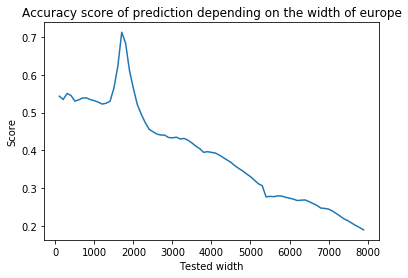

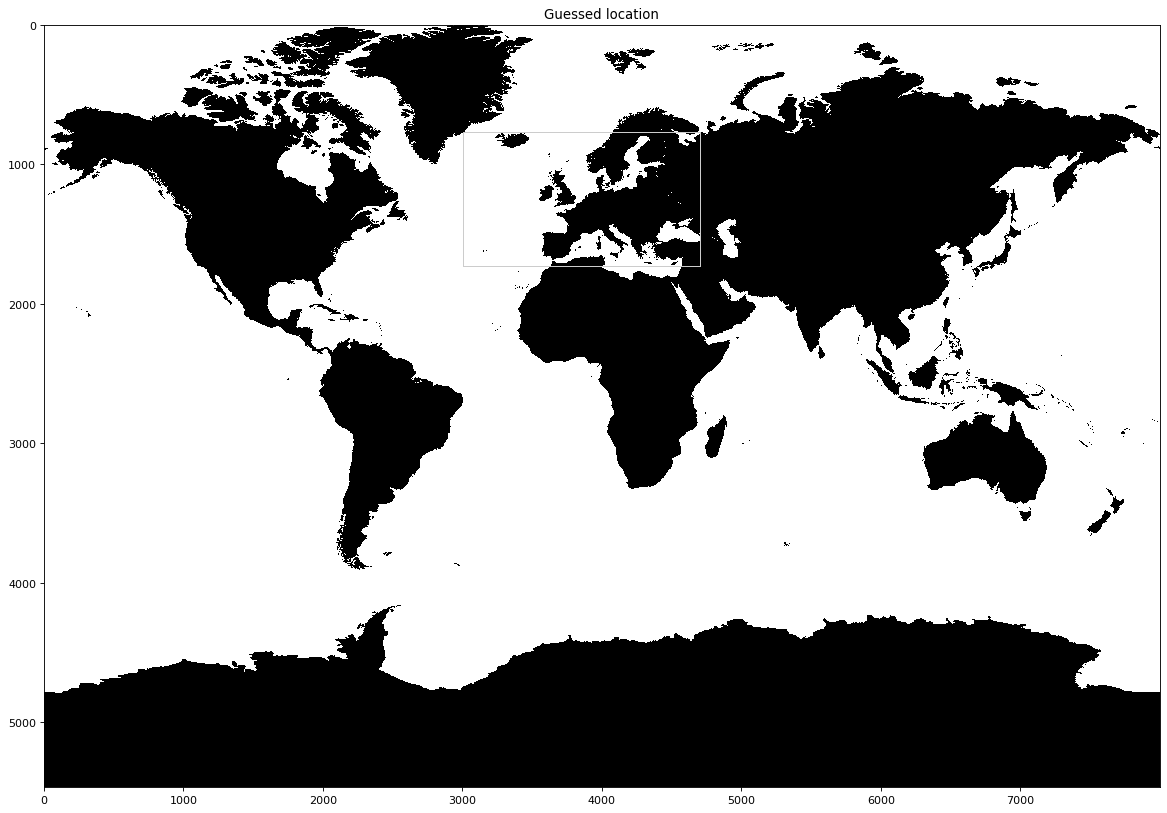

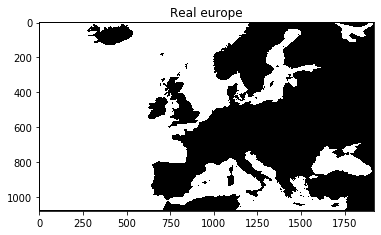

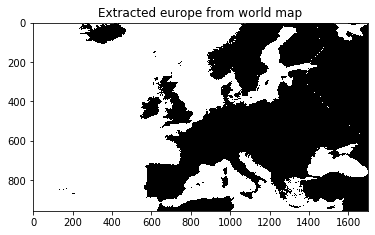

testing between 1500 and 2000 with a step of  30


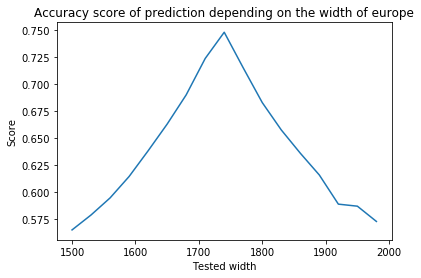

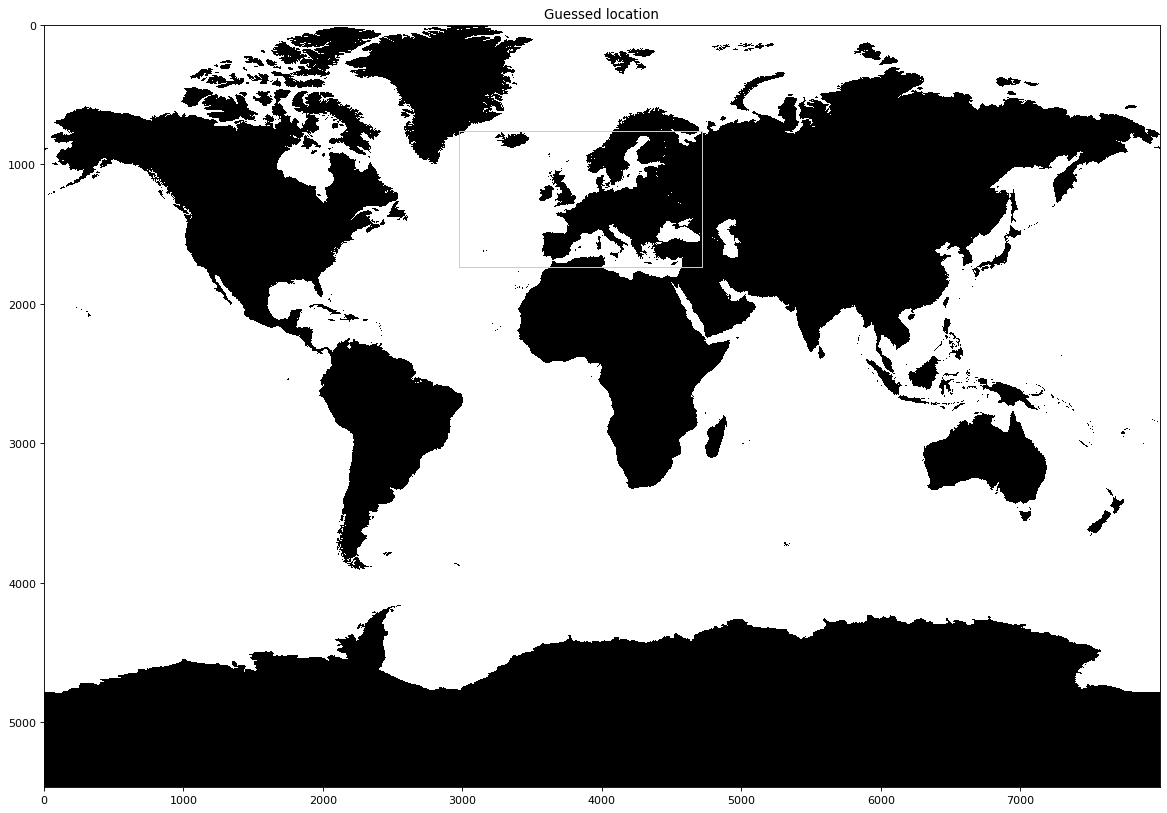

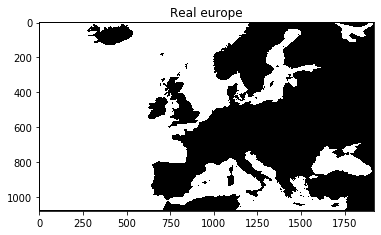

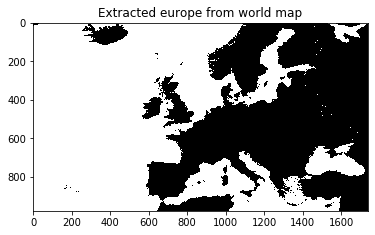

testing between 1680 and 1830 with a step of  10


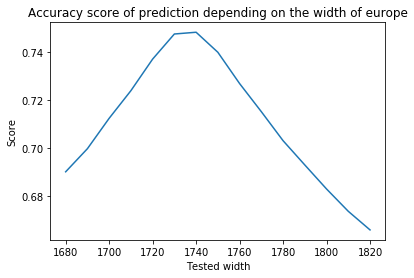

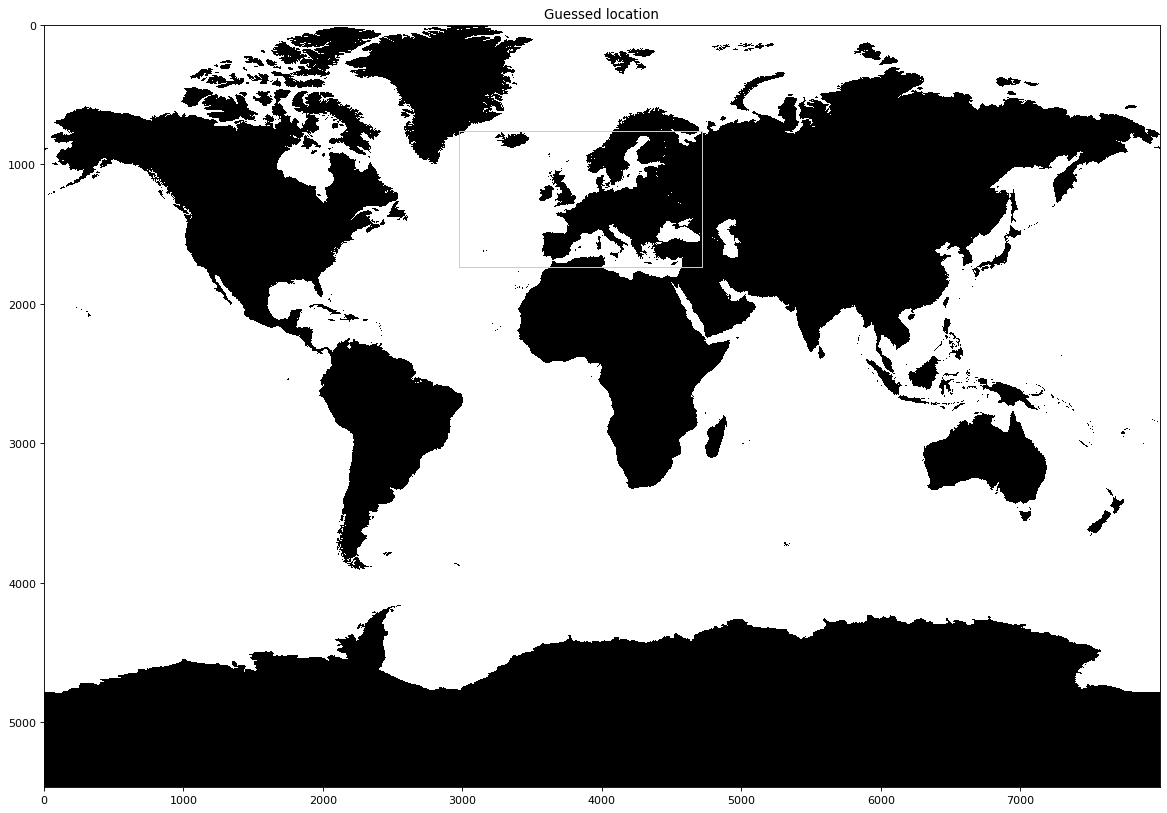

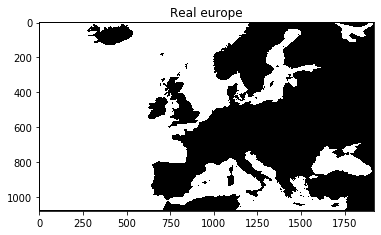

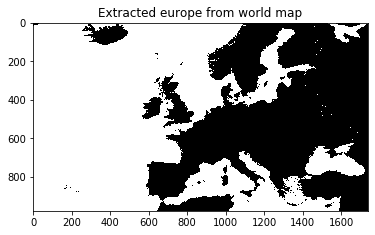

testing between 1720 and 1770 with a step of  1


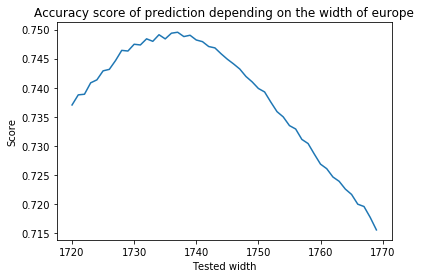

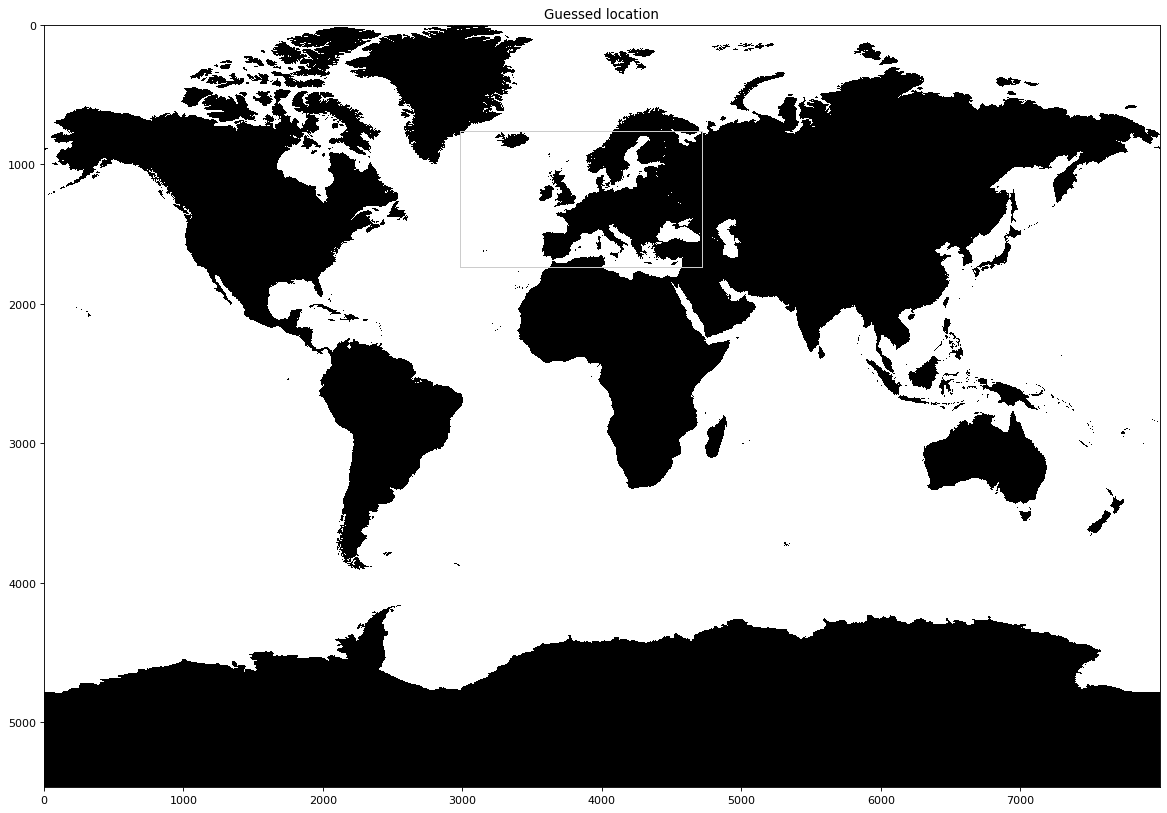

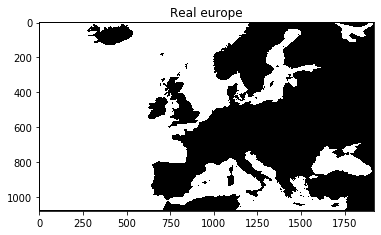

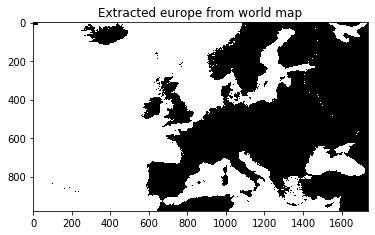

Within the png world map, the europe is a rectangle starting from  (2983, 768)  with a size of (1737, 559)


In [11]:
from tqdm.notebook import tqdm
from IPython.display import display, HTML
import pandas as pd

def get_best_guess(df) : 
    best_guess = df.iloc[0]
    return (int(best_guess['x']),int(best_guess['y']) , int(best_guess['width']))


# Minimum width will be 100, maximum will be the world's width
search_interval = (100, world_picture.shape[1])
# Europe will first be resized with a step of 30 pixel, then with a step of 10 px, then 1px to provide an accurate prediction
steps = [100, 30, 10, 1]
min_width, max_width = search_interval
for step in steps :
    df = pd.DataFrame([], columns=['width','x', 'y', 'score'])
    print('testing between', min_width, 'and', max_width, 'with a step of ', step)
    for width in tqdm(range(min_width, max_width, step)) :
        height = int(width/ratio)
        if height > world_picture.shape[0]:
            print('reached maximum world\'s height')
            break
        europe_resized = cv2.resize(europe_picture, (width, int(width/ratio)))
        x, y = getPosition(world_picture, europe_resized)
        match = extract_window(x, y, width)
        df = df.append({
            'width' :width,
            'score' : image_equality_score(europe_resized, match),
            'x' : x,
            'y' : y
        }, ignore_index=True)
    plt.plot(df['width'], df['score'])
    plt.xlabel('Tested width')
    plt.ylabel('Score')
    plt.title('Accuracy score of prediction depending on the width of europe')
    plt.show()
    df = df.sort_values(by=['score'], ascending=False)
    (x, y, width) = get_best_guess(df)
    display_location_on_world_map(x, y, width)
    display_img(europe_picture, 'Real europe')
    display_img(extract_window(x, y, width), 'Extracted europe from world map')
    # Refines the search interval
    min_width = int(df[:5]['width'].min())
    max_width = int(df[:5]['width'].max() + step)
print('Within the png world map, the europe is a rectangle starting from ', (x, y), ' with a size of', (width, int(height/ratio)))

## In SVG coordinates
Once the position is found on the png image, it can be translated to svg coordinates

In [12]:
def toSVGCoord(coords):
    x, y = coords
    height_png, width_png = world_picture.shape
    width_svg , height_svg = (2269.4568, 1550.3625)
    width_ratio, height_ratio = (width_svg/width_png, height_svg/height_png)
    return (x*width_ratio, y*height_ratio)

width_svg, height_svg = toSVGCoord((width, int(height/ratio)))
print('In the SVG viewbox, it would be (x, y) =', toSVGCoord((x, y)), 'size:', width_svg, 'x', height_svg)

In the SVG viewbox, it would be (x, y) = (846.2237043, 217.87344922232387) size: 492.7558077 x 158.58236733760293
